# Machine Learning and Predictive Maintenance

Predictive maintenance leverages machine learning to analyze operational data, anticipate potential failures, and schedule timely maintenance. This approach helps avoid unexpected downtime and extends the lifespan of equipment. 

In the automotive industry, companies like Tesla are integrating machine learning to predict vehicle component failures before they occur. This is achieved by analyzing data from various sensors in the vehicle, enabling proactive replacement of parts and software updates that enhance performance and safety.

In aviation, predictive maintenance can be particularly critical. Airlines utilize machine learning models to monitor aircraft health in real-time, analyzing data from engines and other critical systems to predict failures. For example, GE uses its [Predix](https://www.ge.com/digital/iiot-platform) platform to process data from aircraft engines, predict when maintenance is needed, and reduce unplanned downtime.

The manufacturing sector also benefits from predictive maintenance. Siemens uses machine learning in its [Insights Hub](https://plm.sw.siemens.com/en-US/insights-hub/) platform to analyze operational data from industrial machinery. This enables them to predict failures and optimize maintenance schedules, thereby improving efficiency and reducing costs.

Energy companies are also applying these techniques to predict the maintenance needs of infrastructure like wind turbines and pipelines. This proactive approach not only ensures operational efficiency but also helps in preventing environmental hazards.

In this exercise, we will explore a simple predictive maintenance scenario using machine learning. We will use a dataset that simulates the sensor data from a car engine, and build a model to predict when an engine is likely running abnormally and might require maintenance.

We will use a [simple dataset](https://www.kaggle.com/datasets/parvmodi/automotive-vehicles-engine-health-dataset) covering data from various sensors, and a target variable indicating whether the engine is running normally or abnormally.

In [1]:
# Load dataset from Kaggle

!kaggle datasets download -d parvmodi/automotive-vehicles-engine-health-dataset -p .data/ --unzip

Dataset URL: https://www.kaggle.com/datasets/parvmodi/automotive-vehicles-engine-health-dataset
License(s): CC0-1.0
100%|████████████████████████████████████████| 595k/595k [00:00<00:00, 1.12MB/s]
100%|████████████████████████████████████████| 595k/595k [00:00<00:00, 1.11MB/s]


In [2]:
# Load engine data from dataset into a pandas dataframe

import pandas as pd

engine = pd.read_csv('.data/engine_data.csv')


## Dataset

As in any ML task, let's start by understanding the content of the dataset.

In [3]:
engine

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0
...,...,...,...,...,...,...,...
19530,902,4.117296,4.981360,4.346564,75.951627,87.925087,1
19531,694,4.817720,10.866701,6.186689,75.281430,74.928459,1
19532,684,2.673344,4.927376,1.903572,76.844940,86.337345,1
19533,696,3.094163,8.291816,1.221729,77.179693,73.624396,1


As we can see it is composed of various sensor data and a target variable indicating whether the engine is running normally or abnormally. Let's make sure there's no missing data.

In [4]:
engine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


In [5]:
# Show a data summary, excluding the 'Engine Condition' column

engine.drop('Engine Condition', axis=1, inplace=False).describe().drop('count').style.background_gradient(cmap='Greens')

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912


The dataset consists of various parameters related to engine performance and maintenance. Engine rpm shows a mean of approximately 791 with a standard deviation of about 268, indicating moderate variability in engine speeds across different observations. Lubrication oil pressure averages around 3.30 with a standard deviation of just over 1, suggesting some fluctuations in oil pressure which might affect engine lubrication and performance.

Fuel pressure has an average value near 6.66 and a standard deviation of approximately 2.76, pointing to considerable variation that could influence fuel delivery and engine efficiency. Similarly, coolant pressure, averaging at about 2.34 with a standard deviation of around 1.04, displays notable variability which is critical for maintaining optimal engine temperature.

Lubrication oil temperature and coolant temperature have averages of roughly 77.64°C and 78.43°C, respectively, with lubrication oil showing less temperature variability (standard deviation of about 3.11) compared to coolant temperature (standard deviation of approximately 6.21). This temperature stability is crucial for maintaining engine health, yet the wider range in coolant temperature could indicate different cooling needs or system efficiencies among the units observed.

Overall, while there is a general consistency in the central values of these parameters, the variability highlighted by the standard deviations and the range between minimum and maximum values underline the complexities and differing conditions under which the engines operate.

To avoid any errors further down in the pipeline, let's also rename all columns so they do not have any whitespaces - this is not strictly necessary, but it can help avoid issues later on.

In [6]:
# To avoid issues further down, let us rename the columns to remove spaces

engine.columns = engine.columns.str.replace(' ', '_')

In [7]:
# Split the data into features and target

X = engine.drop('Engine_Condition', axis=1)
y = engine['Engine_Condition']

y.value_counts()

Engine_Condition
1    12317
0     7218
Name: count, dtype: int64

## Balancing the data

Notice the imbalance in the target variable `Engine_Condition`, with a split between categories of 58%/42%. This imbalance could affect the model's ability to learn the patterns in the data, especially if the minority class (abnormal engine operation) is underrepresented. We will address this issue with a resampling technique called SMOTE.

In [8]:
# There is a class imbalance in the target variable. We will use the SMOTE technique to balance the classes.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_resampled, y_resampled = sm.fit_resample(X, y)

```{index} Imbalanced data ; SMOTE
```

```{tip}
SMOTE stands for Synthetic Minority Over-sampling Technique. It's a statistical technique for increasing the number of cases in a dataset in a balanced way. SMOTE works by creating synthetic samples rather than by oversampling with replacement. It's particularly useful when dealing with imbalanced datasets, where one class is significantly outnumbered by the other(s). 

The way SMOTE works is by first selecting a minority class instance and then finding its k-nearest minority class neighbors. The synthetic instances are then created by choosing one of the k-nearest neighbors and drawing a line between the two in feature space. The synthetic instances are points along the line, randomly placed between the two original instances. This approach not only augments the dataset size but also helps to generalize the decision boundaries, as the synthetic samples are not copies of existing instances but are instead new, plausible examples constructed in the feature space neighborhood of existing examples. 

By using SMOTE, the variance of the minority class increases, which can potentially improve the classifier's performance by making it more robust and less likely to overfit the minority class based on a small number of samples. This makes it particularly useful in scenarios where acquiring more examples of the minority class is impractical.
```

## Visualising the distributions

Now that we have balanced the data, let's visualize the distributions of the features to understand their spread and identify any patterns or outliers. This will help us determine which features are most relevant for predicting engine condition, if any.

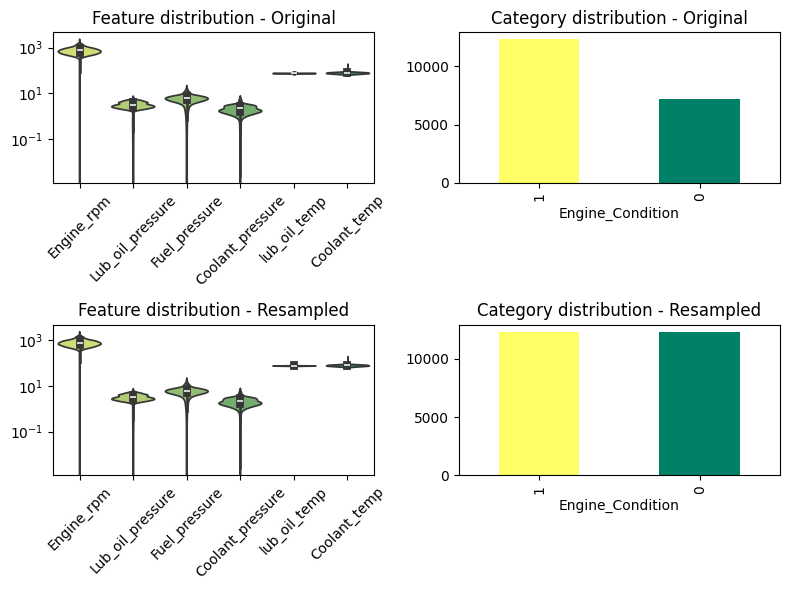

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_violin(data, ax):
    # Create a violin plot using the specified color palette
    sns.violinplot(data=data, palette='summer_r', ax=ax)

    # Rotate x-tick labels for better readability - apply to the specific axes
    ax.tick_params(axis='x', rotation=45)

    # Apply a log scale to the y-axis of the specific axes
    ax.set_yscale('log')

    return ax

def plot_bar(data, ax):
    # Get the unique values and their frequency
    value_counts = data.value_counts()

    # Generate a list of colors, one for each unique value
    colors = plt.cm.summer_r(np.linspace(0, 1, num=len(value_counts)))

    # Plot with a different color for each bar
    value_counts.plot(kind='bar', color=colors, ax=ax)

    return plt

# Plot the distribution of the resampled features, together with the original features as a facet grid
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # Create a 2x2 grid of subplots

plot_violin(X, ax=axs[0, 0])
plot_bar(y, ax=axs[0, 1])

plot_violin(X_resampled, ax=axs[1, 0])
plot_bar(y_resampled, ax=axs[1, 1])

axs[0, 0].set_title('Feature distribution - Original')
axs[0, 1].set_title('Category distribution - Original')
axs[1, 0].set_title('Feature distribution - Resampled')
axs[1, 1].set_title('Category distribution - Resampled')

plt.tight_layout()
plt.show()

We see the expected spread as indicated before. Another important step is to understand if there is a clear correlation between the features and the target variable. This can be done by plotting a correlation matrix.

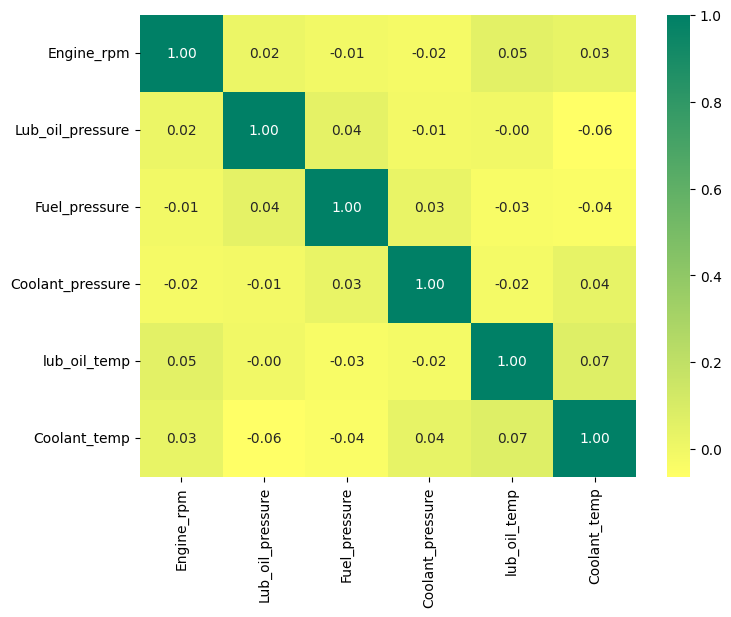

In [10]:
# Plot a correlation matrix of the features

corr = X_resampled.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='summer_r', fmt='.2f')
plt.show()

Notice how there are no strong correlations between the features and the target variable. This suggests that the features might not be linearly related to the target, and more complex relationships might be at play, or that the features are not informative enough to predict the target variable.

It points at needing to use more advanced models to capture the underlying patterns in the data, rather than simple linear models.

## Reducing dimensionality for analysis

To further understand the data, we can reduce the dimensionality of the dataset using t-SNE (t-distributed Stochastic Neighbor Embedding). This technique is useful for visualizing high-dimensional data in 2D or 3D, allowing us to explore the data's structure and identify any clusters or patterns.

In [11]:
import plotly.express as px
from sklearn.manifold import TSNE

# Set up the t-SNE with 3 components for a 3D visualization
tsne = TSNE(n_components=3, random_state=42)

# Fit and transform the data
X_tsne = tsne.fit_transform(X_resampled)

# Create a DataFrame for better handling with Plotly
df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2', 'Component 3'])
df_tsne['y'] = y_resampled  # Add the target variable for coloring

# Plot using Plotly Express with categorical colors
fig = px.scatter_3d(df_tsne, x='Component 1', y='Component 2', z='Component 3',
                    color='y',  # This column is now treated as categorical
                    color_discrete_sequence=px.colors.qualitative.Plotly,  # Using a qualitative color scale
                    opacity=0.5, size_max=10)

fig.update_layout(title='3D t-SNE visualization of the resampled data',
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

That makes for an interesting structure, but unfortunately it doesn't seem to show any clear separation between the two classes. This could indicate that the data is not easily separable in the feature space, which might make it challenging to build a model that accurately predicts engine condition based on these features. However, it's still worth exploring different models to see if they can capture the underlying patterns in the data.

## Testing a couple of models

We have mentioned that the features might not be linearly related to the target variable, and more complex relationships might be at play. To address this, we can use a [Random Forest](random-forests.ipynb) classifier, which is an ensemble learning method that combines multiple decision trees to improve predictive performance. Random Forest models are known for their robustness and ability to capture complex relationships in the data, making them suitable for this task.

First we will split the data into training and testing sets, and then train the Random Forest model on the training data. We will evaluate the model's performance on the test data using metrics such as accuracy, precision, recall, and F1 score. Notice how we are stratifying the split to ensure that the distribution of the target variable is preserved in both the training and testing sets.

In [ ]:
# Create a train-test split of the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    test_size=0.2,
                                                    stratify=y_resampled,
                                                    random_state=42)

Let's now train the Random Forest Model and evaluate its performance. We will do this by searching for the best hyperparameters using a grid search.

In [26]:
# Do a grid search to find the best hyperparameters for a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

# Train the model with the best hyperparameters
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


KeyboardInterrupt: 

That's an ok(ish) performance, but this was somewhat expected given the lack of strong correlations between the features and the target variable. However, the Random Forest model is able to capture some of the underlying patterns in the data, achieving an accuracy of around 70% on the test set.

```{note}
In a balanced binary classification scenario where each class has a 50% probability, random guessing would typically result in an accuracy of 50%. If a model achieves an accuracy of 70%, it is performing better than random guessing by a margin of 20 percentage points.

To further quantify this improvement:

- **Random Guessing Accuracy**: 50%
- **Model Accuracy**: 70%
- **Improvement**: $(70\% - 50\% = 20\%)$

This means the model's accuracy is 40% better than what would be expected by random chance, calculated by the formula:

$$
\text{Improvement Percentage} = \left( \frac{\text{Model Accuracy} - \text{Random Guessing Accuracy}}{\text{Random Guessing Accuracy}} \right) \times 100\% = \left( \frac{70\% - 50\%}{50\%} \right) \times 100\% = 40\%
$$

Thus, the model is performing significantly better than random guessing in this balanced classification problem. This is a good indication that it is learning and able to effectively discriminate between the two classes beyond mere chance.
```

Let us now look at the feature importances, as determined by the model. This will help us understand which features are most relevant for predicting engine condition.

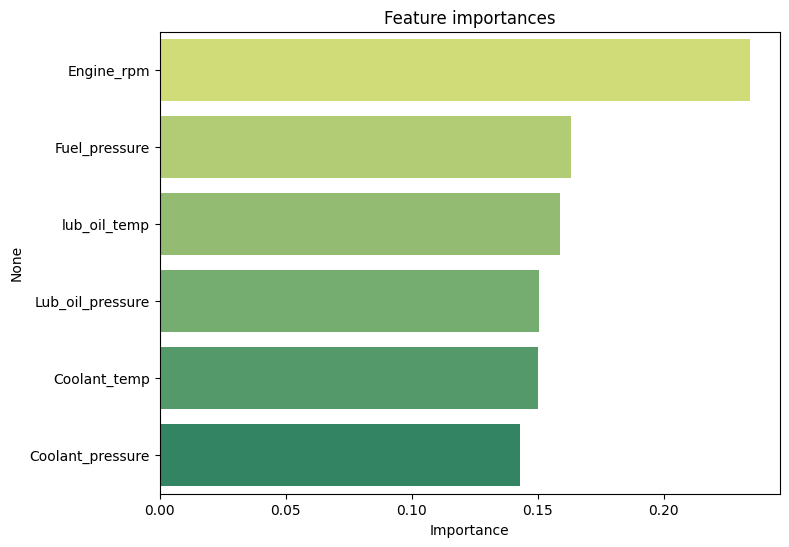

In [17]:
# Plot the feature importances

importances = rf.feature_importances_

importances_df = pd.DataFrame(importances, index=X.columns, columns=['Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances_df, x='Importance', hue=importances_df.index, y=importances_df.index, palette='summer_r', legend=False)
plt.title('Feature importances')
plt.show()

## Final remarks

In this exercise, we explored a simple predictive maintenance scenario using machine learning. We used a dataset simulating sensor data from a car engine and built a Random Forest model to predict when an engine is likely running abnormally and might require maintenance.

```{note}
The dataset was pretty small, with less than 5000 observations, which could limit the model's ability to generalize to new data. In practice, having more data would be beneficial for training a more robust model that can capture the underlying patterns in the data more effectively.
```

We reached an accuracy of around 70% on the test set, indicating that the model is able to capture some of the underlying patterns in the data. However, the lack of strong correlations between the features and the target variable suggests that more complex relationships might be at play, which could be challenging to capture with the current features. Therefore it would be worth considering additional features in such a scenario.